## Łańcuch Zobowiązań (ang. Chain of Responsibility)

**Typ**: behawioralny \
**Zakres**: obiektowy

<div style="border: solid 1px;padding: 20px;text-align: center">
    Wzorzec <b>łańcuch zobowiązań</b> pozwala uniknąć powiązania nadawcy żądania z odbiorcą poprzez umożliwienie obsłużenia żadania więcej niż jednemu obiektowi. Łączy w łańcuch obiekty odbiorców i przekazuje żądanie wzdłuż łańcucha, aż któryś z obiektów je obsłuży.
</div>

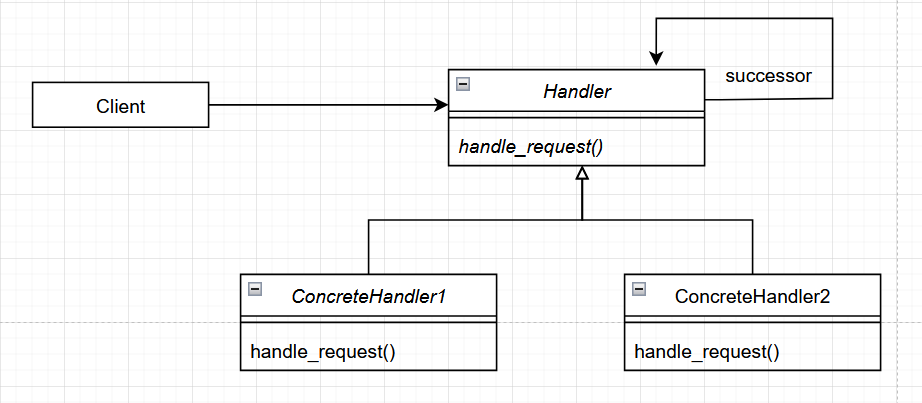

### Problem - sztywne powiązanie nadawcy z odbiorcą

System wsparcia technicznego ma 3 poziomy:
- **Basic Support** - proste pytania (resetowanie hasła)
- **Advanced Support** - techniczne problemy
- **Manager** - skargi i zwroty

**Problem:** Jak przekazać zgłoszenie właściwej osobie bez sztywnego powiązania?

### Naiwne podejście - `if/elif` decydujące o odbiorcy

In [ ]:
class SupportSystem:
    def handle_request(self, request_type, message):
        # ❌ Sztywne powiązanie - musi znać wszystkie poziomy
        if request_type == "password_reset":
            print(f"👤 Basic Support: Resetuję hasło - {message}")
        elif request_type == "technical":
            print(f"🔧 Advanced Support: Rozwiązuję problem - {message}")
        elif request_type == "complaint":
            print(f"👔 Manager: Rozpatruję skargę - {message}")
        else:
            print(f"Nie mogę obsłużyć: {message}")

In [ ]:
system = SupportSystem()
system.handle_request("password_reset", "Zapomniałem hasła")
system.handle_request("technical", "Aplikacja się crashuje")
system.handle_request("complaint", "Chcę zwrot pieniędzy")

**Problemy:**
- ❌ **Sztywne powiązanie** - `SupportSystem` musi znać wszystkie typy i poziomy
- ❌ Dodanie poziomu (np. "Senior Manager") → **zmiana `SupportSystem`**
- ❌ **Złamanie SRP** - jedna klasa decyduje o wszystkim
- ❌ Brak możliwości **delegacji** ("nie mogę obsłużyć, przekaż dalej")

### Rozwiązanie - wzorzec Łańcuch Zobowiązań

**Idea:** Każdy handler **próbuje obsłużyć** żądanie. Jeśli nie potrafi → **przekazuje dalej** w łańcuchu.

### Krok 1: Abstrakcyjny Handler

In [ ]:
from abc import ABC, abstractmethod

class SupportHandler(ABC):
    """Abstrakcyjny handler w łańcuchu"""
    
    def __init__(self):
        self._next_handler = None  # Następny handler w łańcuchu
    
    def set_next(self, handler):
        """Ustawia następny handler w łańcuchu"""
        self._next_handler = handler
        return handler  # Dla fluent interface
    
    def handle(self, request_type: str, message: str):
        """Obsługuje żądanie lub przekazuje dalej"""
        if self.can_handle(request_type):
            self.process(message)
        elif self._next_handler:
            # Nie mogę obsłużyć - przekaż dalej!
            self._next_handler.handle(request_type, message)
        else:
            # Koniec łańcucha - nikt nie obsłużył
            print(f"❌ Nikt nie może obsłużyć: {message}")
    
    @abstractmethod
    def can_handle(self, request_type: str) -> bool:
        """Czy ten handler potrafi obsłużyć żądanie?"""
        pass
    
    @abstractmethod
    def process(self, message: str):
        """Obsługuje żądanie"""
        pass

**Kluczowy mechanizm:**
- Handler sprawdza `can_handle()` - czy potrafi obsłużyć
- Jeśli **TAK** → `process()`
- Jeśli **NIE** → `_next_handler.handle()` (przekaż dalej)

### Krok 2: Konkretne handlery

In [ ]:
class BasicSupport(SupportHandler):
    """Poziom 1 - proste pytania"""
    
    def can_handle(self, request_type: str) -> bool:
        return request_type == "password_reset"
    
    def process(self, message: str):
        print(f"👤 Basic Support: Resetuję hasło - {message}")


class AdvancedSupport(SupportHandler):
    """Poziom 2 - problemy techniczne"""
    
    def can_handle(self, request_type: str) -> bool:
        return request_type == "technical"
    
    def process(self, message: str):
        print(f"🔧 Advanced Support: Rozwiązuję problem - {message}")


class Manager(SupportHandler):
    """Poziom 3 - skargi"""
    
    def can_handle(self, request_type: str) -> bool:
        return request_type == "complaint"
    
    def process(self, message: str):
        print(f"👔 Manager: Rozpatruję skargę - {message}")

**Każdy handler:**
- Wie **co potrafi** obsłużyć (`can_handle()`)
- **NIE wie** o innych handlerach (luźne powiązanie)
- Automatycznie **przekazuje dalej** jeśli nie potrafi

### Krok 3: Budowanie łańcucha

In [ ]:
# Tworzenie handlerów
basic = BasicSupport()
advanced = AdvancedSupport()
manager = Manager()

# Budowanie łańcucha: Basic → Advanced → Manager
basic.set_next(advanced).set_next(manager)

# Możemy też tak:
# basic.set_next(advanced)
# advanced.set_next(manager)

### Krok 4: Użycie - wysyłanie do łańcucha

In [ ]:
# Wysyłamy wszystkie żądania do PIERWSZEGO handlera
# Łańcuch sam zadecyduje kto obsłuży

basic.handle("password_reset", "Zapomniałem hasła")
# Basic obsługuje

basic.handle("technical", "Aplikacja się crashuje")
# Basic nie potrafi → przekazuje → Advanced obsługuje

basic.handle("complaint", "Chcę zwrot pieniędzy")
# Basic nie potrafi → Advanced nie potrafi → Manager obsługuje

basic.handle("unknown", "Coś innego")
# Nikt nie potrafi → kończy się na Manager (koniec łańcucha)

**Zalety:**
- ✅ **Luźne powiązanie** - nadawca nie zna odbiorcy
- ✅ **Dodanie poziomu** - nowa klasa + `set_next()` (bez zmian w istniejących!)
- ✅ **Elastyczna kolejność** - możesz przestawiać łańcuch
- ✅ **SRP** - każdy handler odpowiada tylko za swój poziom

## Jak to działa?

**Żądanie "wędruje" przez łańcuch, aż znajdzie handler, który potrafi je obsłużyć.**

## Struktura wzorca

**Elementy wzorca Łańcuch Zobowiązań:**

1. **Handler** - `SupportHandler`
   - Interfejs dla wszystkich handlerów
   - Przechowuje referencję do następnego (`_next_handler`)
   - Implementuje mechanizm przekazywania (`handle()`)

2. **ConcreteHandler** - `BasicSupport`, `AdvancedSupport`, `Manager`
   - Konkretny handler
   - Decyduje czy obsłużyć (`can_handle()`)
   - Obsługuje żądanie (`process()`)

3. **Client**
   - Buduje łańcuch (`set_next()`)
   - Wysyła żądanie do pierwszego handlera

**Kluczowa właściwość:**
> Handler nie wie kto go wywołał ani kto jest dalej w łańcuchu (oprócz bezpośredniego następcy)

## Przykład 2 - Logowanie z poziomami

In [ ]:
from abc import ABC, abstractmethod

# Poziomy logowania
DEBUG = 1
INFO = 2
ERROR = 3

# ════════════════════════════════════════════════════════════
# Handler
# ════════════════════════════════════════════════════════════
class Logger(ABC):
    def __init__(self, level: int):
        self.level = level
        self._next_logger = None
    
    def set_next(self, logger):
        self._next_logger = logger
        return logger
    
    def log(self, level: int, message: str):
        # Loguj jeśli poziom >= twojego poziomu
        if level >= self.level:
            self.write(message)
        
        # ZAWSZE przekaż dalej (logowanie do wielu miejsc!)
        if self._next_logger:
            self._next_logger.log(level, message)
    
    @abstractmethod
    def write(self, message: str):
        pass


# ════════════════════════════════════════════════════════════
# Konkretne loggery
# ════════════════════════════════════════════════════════════
class ConsoleLogger(Logger):
    def write(self, message: str):
        print(f"🖥️  Console: {message}")


class FileLogger(Logger):
    def write(self, message: str):
        print(f"📁 File: {message}")


class EmailLogger(Logger):
    def write(self, message: str):
        print(f"📧 Email: {message}")

In [ ]:
# Budowanie łańcucha
# Console: DEBUG i wyżej (wszystko)
# File: INFO i wyżej (INFO, ERROR)
# Email: tylko ERROR

console = ConsoleLogger(DEBUG)
file = FileLogger(INFO)
email = EmailLogger(ERROR)

console.set_next(file).set_next(email)

# Test
print("=== DEBUG ===")
console.log(DEBUG, "Szczegóły debugowania")
# Tylko Console

print("\n=== INFO ===")
console.log(INFO, "Aplikacja wystartowała")
# Console + File

print("\n=== ERROR ===")
console.log(ERROR, "Krytyczny błąd!")
# Console + File + Email

Tak właśnie działa mechanizm propagacji logów w Pythonowym loggerze (`import logging`) - implementuje wzorzec Łańcuch odpowiedzialności.

**Różnica:**
- W przykładzie 1 (Support): **jeden** handler obsługuje (przerywa łańcuch)
- W przykładzie 2 (Logger): **wiele** handlerów może obsłużyć (kontynuuje łańcuch)

## Warianty wzorca

**Wariant 1: Jeden handler obsługuje (przerywa)**
```python
def handle(self, request):
    if self.can_handle(request):
        self.process(request)  # Obsługuje
        # NIE przekazuje dalej - koniec!
    elif self._next:
        self._next.handle(request)  # Przekaż dalej
```

**Wariant 2: Wiele handlerów obsługuje (kontynuuje)**
```python
def handle(self, request):
    if self.can_handle(request):
        self.process(request)  # Obsługuje
    
    # ZAWSZE przekaż dalej (nawet jeśli obsłużył)
    if self._next:
        self._next.handle(request)
```

**Wariant 3: Handler może przerwać łańcuch**
```python
def handle(self, request):
    handled = self.process(request)  # Zwraca True/False
    
    if not handled and self._next:
        self._next.handle(request)  # Przekaż tylko jeśli nie obsłużył
```

## Kiedy używać wzorca Łańcuch Zobowiązań?

Wzorzec Łańcuch Zobowiązań stosuj gdy:

1. **Więcej niż jeden obiekt może obsłużyć żądanie**
   - Nie wiesz z góry który
   - Handler wybierany dynamicznie

2. **Chcesz uniknąć sztywnego powiązania nadawcy z odbiorcą**
   - Nadawca nie zna odbiorcy
   - Odbiorca nie zna nadawcy

3. **Zestaw handlerów jest dynamiczny**
   - Możesz dodawać/usuwać handlery
   - Możesz zmieniać kolejność

4. **Masz hierarchię poziomów uprawnień/kompetencji**
   - Support L1 → L2 → L3
   - Junior → Senior → Lead

**Przykłady praktyczne:**
- System wsparcia (level 1, 2, 3)
- Logowanie (console, file, email)
- Event handling w GUI (widget → parent → window)
- Middleware w web frameworks (Django, Express)


## Łańcuch Zobowiązań vs Dekorator

**Oba używają łańcucha obiektów, ale:**

| Aspekt | Łańcuch Zobowiązań | Dekorator |
|--------|-------------------|----------|
| **Cel** | Przekazywanie żądania | Dodawanie funkcjonalności |
| **Obsługa** | **Jeden** handler obsługuje | **Wszystkie** dekoratory przetwarzają |
| **Przerwanie** | Może się **przerwać** | **Zawsze** przechodzi przez wszystkie |
| **Kolejność** | Może **nie mieć** znaczenia | **Ma** znaczenie |

**Łańcuch Zobowiązań:**
```python
basic.handle("technical", "Problem")
# Basic NIE obsługuje → przekazuje → Advanced obsługuje (KONIEC)
# Manager NIE dostaje żądania
```

**Dekorator:**
```python
coffee = Chocolate(Milk(Coffee()))
coffee.cost()
# Chocolate → Milk → Coffee
# WSZYSCY dodają swój koszt (suma)
```

## Podsumowanie

Wzorzec Łańcuch Zobowiązań:
- ✅ **Luźne powiązanie** - nadawca nie zna odbiorcy
- ✅ **Elastyczność** - dodawanie/usuwanie handlerów bez zmian w kodzie
- ✅ **SRP** - każdy handler odpowiada tylko za swój poziom
- ✅ **Dynamiczna kolejność** - przestawianie łańcucha
- ⚠️ **Brak gwarancji** - żądanie może nie być obsłużone
- ⚠️ **Trudne debugowanie** - żądanie "wędruje" przez łańcuch

**Kluczowa idea:**
> **Łańcuch handlerów** - każdy próbuje obsłużyć, jeśli nie potrafi → **przekazuje dalej**

**Struktura:**
```python
class Handler(ABC):
    def __init__(self):
        self._next = None
    
    def set_next(self, handler):
        self._next = handler
        return handler
    
    def handle(self, request):
        if self.can_handle(request):
            self.process(request)  # Obsłuż
        elif self._next:
            self._next.handle(request)  # Przekaż dalej

# Budowanie łańcucha
h1 = Handler1()
h2 = Handler2()
h3 = Handler3()
h1.set_next(h2).set_next(h3)

# Użycie
h1.handle(request)  # Wysyłamy do pierwszego
```

**Istota wzorca:**
- **Delegacja:** Handler decyduje: obsłużyć czy przekazać dalej
- **Luźne powiązanie:** Handler zna tylko następnika (`_next`)
- **Elastyczność:** Łatwo dodać/usunąć/przestawić handlery

**Dwa warianty:**
1. **Jeden obsługuje** - przerywa łańcuch (Support)
2. **Wiele obsługuje** - kontynuuje łańcuch (Logger)